# 深圳进出口量预测ARIMA模型

## 使用到的模块及其安装

 - Python version: 3.11.0
 - Pandas version: 2.2.3
    - pip install pandas==2.2.3
 - Matplotlib version: 3.10.1
    - pip install matplotlib==3.10.1
 - Statsmodels version:
    - pip install statsmodels==0.14.4

In [138]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline

In [139]:
df_total=pd.read_excel('深圳外贸货物吞吐量.xlsx')
print('数据预览：\n', df_total.head())

数据预览：
           时间  外贸货物吞吐量(万吨)
0 2020-01-01         1675
1 2020-02-01          834
2 2020-03-01         1388
3 2020-04-01         1308
4 2020-05-01         1375


## 进出口总额预测处理

In [140]:
# 修改列标题
df_total.columns = ["时间", "数据"]
# 转化月份为时间数据
df_total['时间']=pd.to_datetime(df_total['时间'])
# df_total['时间'] = df_total['时间'].dt.strftime('%Y-%m-%d')
# 设置时间月份索引
df_total.set_index('时间',inplace=True)
df_total.head()

,数据
时间,
2020-01-01,1675
2020-02-01,834
2020-03-01,1388
2020-04-01,1308
2020-05-01,1375


In [141]:
# 获取数据描述
df_total.describe()

,数据
count,59.000000
mean,1782.949153
std,269.043223
min,834.000000
25%,1697.500000
50%,1802.000000
75%,1885.500000
max,2358.000000


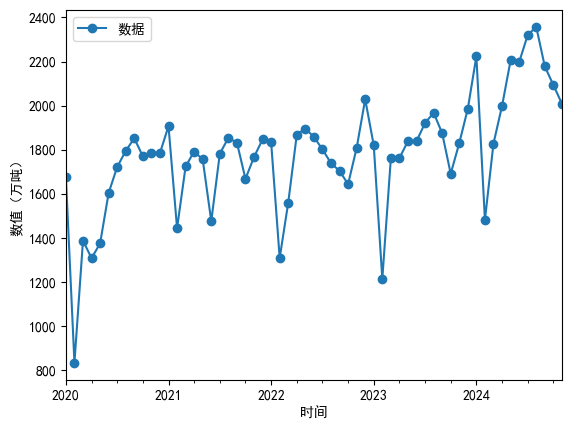

In [142]:
# 原始数据可视化绘图
df_total.plot(kind='line', marker='o')
plt.ylabel('数值（万吨）')
plt.show()

In [143]:
# ADF 检验函数
# H0：它是非平稳的  
# H1：它是平稳的
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF检验统计量', 'p值', '使用的滞后数', '使用的观测值数量']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。")
    else:
        print("反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。")

In [144]:
# ADF 检验1：原始数据不平稳
adfuller_test(df_total['数据'])

ADF检验统计量 : 1.985637959817927
p值 : 0.9986539961317406
使用的滞后数 : 11
使用的观测值数量 : 47
反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。


In [145]:
# 差分操作
df_total['一阶差分'] = df_total['数据'] - df_total['数据'].shift(1)   # 一阶差分
df_total['季节性差分'] = df_total['数据'] - df_total['数据'].shift(12)  # 季节性差分
df_total.head(14)

,数据,一阶差分,季节性差分
时间,,,
2020-01-01,1675,NaN,NaN
2020-02-01,834,-841.0,NaN
2020-03-01,1388,554.0,NaN
2020-04-01,1308,-80.0,NaN
2020-05-01,1375,67.0,NaN
2020-06-01,1604,229.0,NaN
2020-07-01,1722,118.0,NaN
2020-08-01,1795,73.0,NaN
2020-09-01,1852,57.0,NaN


In [146]:
# ADF 检验2：经过差分处理后已经平稳
print("一阶差分：")
adfuller_test(df_total['一阶差分'].dropna())
print("\n季节性差分：")
adfuller_test(df_total['季节性差分'].dropna())

一阶差分：
ADF检验统计量 : -2.7390841747695376
p值 : 0.06751572703877717
使用的滞后数 : 11
使用的观测值数量 : 46
反对零假设的弱证据，时间串行有一个单位根，表明它是非平稳的。

季节性差分：
ADF检验统计量 : -3.511069602668428
p值 : 0.007707312897361116
使用的滞后数 : 0
使用的观测值数量 : 46
反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。


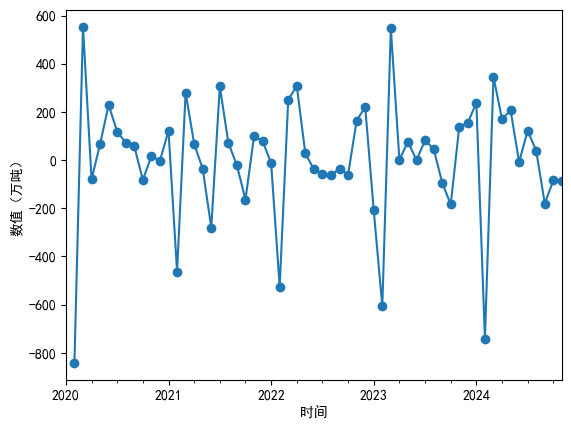

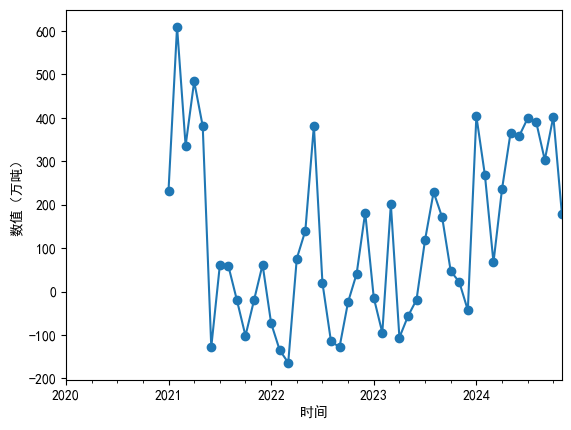

In [147]:
# 绘制可视化图像
df_total['一阶差分'].plot(kind='line', marker='o')
plt.ylabel('数值（万吨）')
plt.show()

df_total['季节性差分'].plot(kind='line', marker='o')
plt.ylabel('数值（万吨）')
plt.show()

### 自动回归模型


自回归模型（AR模型）的一般形式：

$$ y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t $$

其中：
- $ y_t $ 是时间序列在时间 t 的值。
- $ c $ 是常数项。
- $ \phi_1, \phi_2, \ldots, \phi_p $ 是模型参数，分别代表不同滞后项的系数。
- $ y_{t-1}, y_{t-2}, \ldots, y_{t-p} $ 是时间序列在 t-1, t-2, ..., t-p 时刻的值，即滞后项。
- $ \varepsilon_t $ 是误差项，通常假设为白噪声序列。
- $ p $ 是模型的阶数，表示考虑的滞后项的数量。

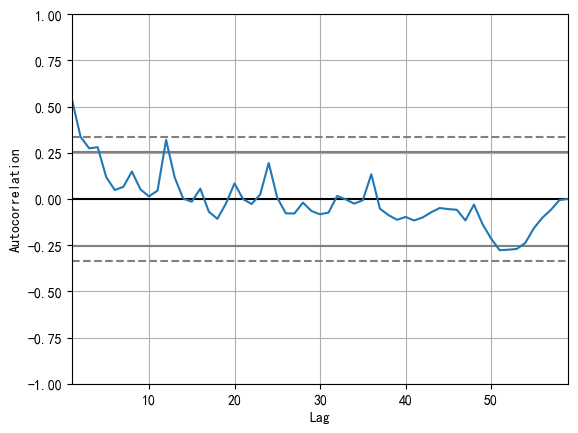

In [148]:
# 绘制自相关图
autocorrelation_plot(df_total['数据'])
plt.show()

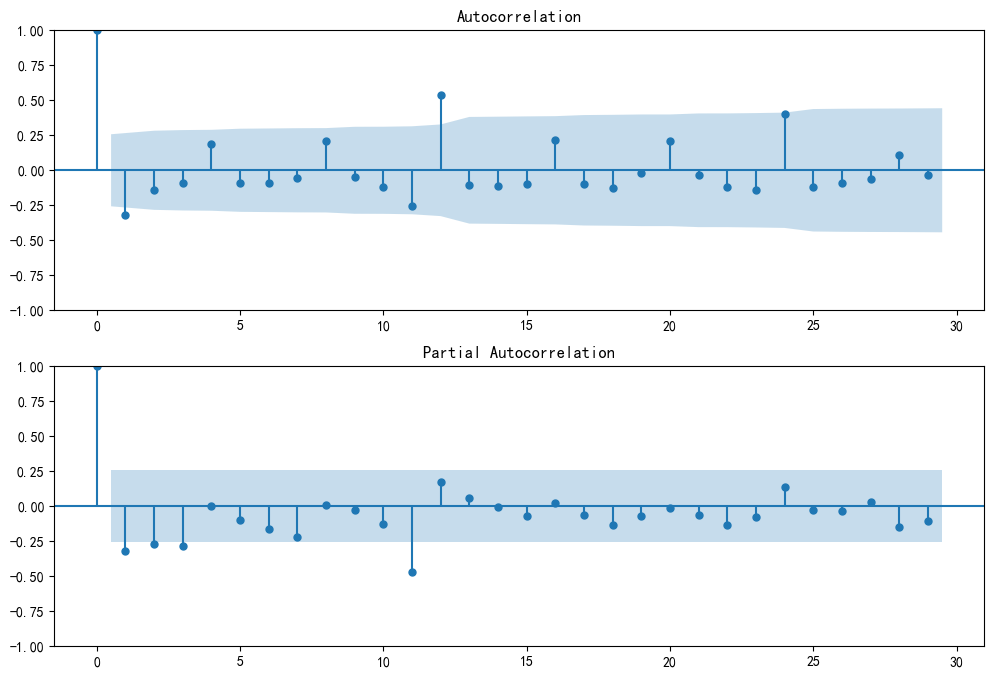

In [149]:
fig1 = plt.figure(figsize=(12,8))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total['一阶差分'].iloc[1:], lags=len(df_total["数据"])//2, ax=ax1)   # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total['一阶差分'].iloc[1:], lags=len(df_total["数据"])//2, ax=ax2)  # 偏自相关函数（PACF）图

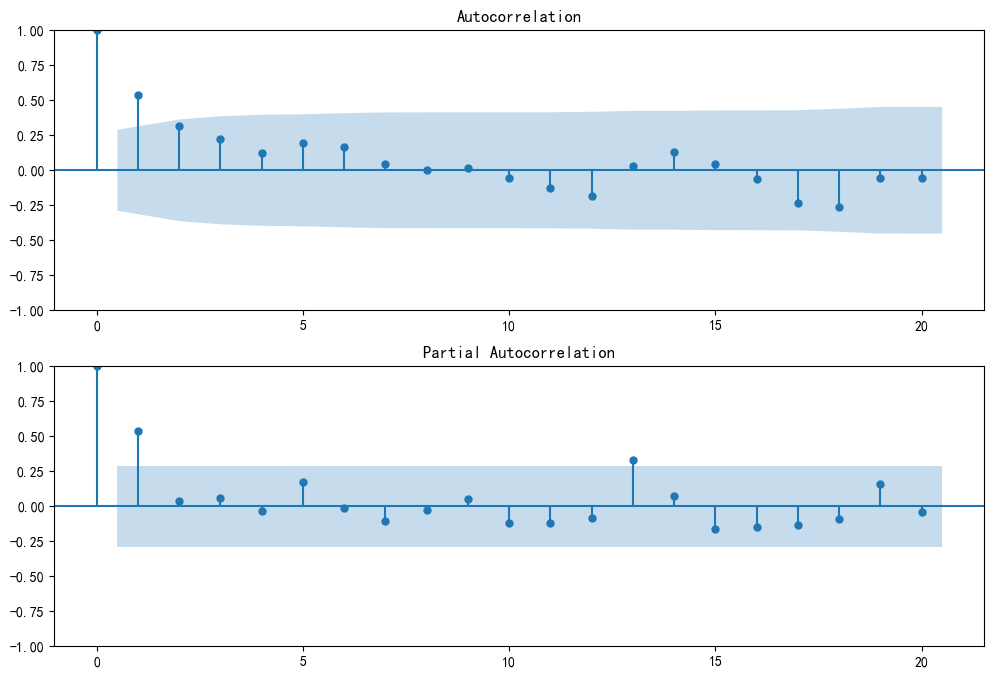

In [150]:
fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total['季节性差分'].iloc[13:], lags=20, ax=ax1)   # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total['季节性差分'].iloc[13:], lags=20, ax=ax2)  # 偏自相关函数（PACF）图

### 拟合

e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<Axes: xlabel='时间'>

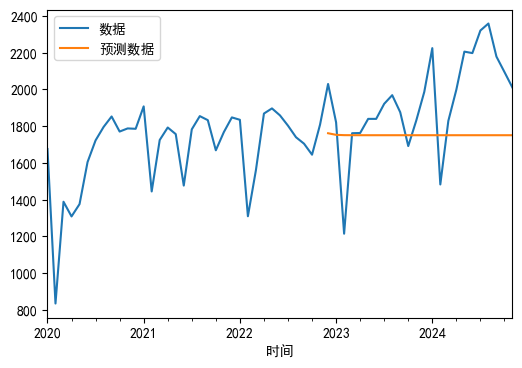

In [151]:
# 一阶差分ARIMA模型
# 使用ARIMA模型对数据进行建模，其中包含一阶差分以使数据平稳
model_one = ARIMA(df_total['数据'], order=(1, 1, 1), freq='MS')
one_fit = model_one.fit()

# 使用拟合后的模型进行预测
df_total['预测数据'] = one_fit.predict(start=35, end=58, dynamic=True)
df_total[['数据', '预测数据']].plot(figsize=(6, 4))

e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
e:\Python\miniconda\envs\ip311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: xlabel='时间'>

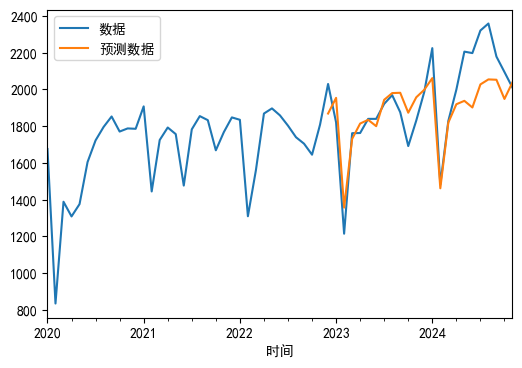

In [152]:
# 季节性差分SARIMAX模型
model_seasonal = sm.tsa.statespace.SARIMAX(df_total['数据'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), freq='MS')
seasonal_fit = model_seasonal.fit()

# 季节性差分绘图
df_total['预测数据'] = seasonal_fit.predict(start=35,end=58,dynamic=True)
df_total[['数据','预测数据']].plot(figsize=(6,4))

In [153]:
future_dates=[df_total.index[-1]+ DateOffset(months=x)for x in range(1,25)]
future_datest_df=pd.DataFrame(index=future_dates[0:],columns=df_total.columns)

In [154]:
# 季节性差分SARIMAX模型的拟合效果更佳
future_df=pd.concat([df_total,future_datest_df])
future_df['预测数据'] = seasonal_fit.predict(start = 59, end = 82, dynamic= True)
future_df.tail()

C:\Users\31561\AppData\Local\Temp\ipykernel_19836\3546076906.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  future_df=pd.concat([df_total,future_datest_df])


,数据,一阶差分,季节性差分,预测数据
2026-07-01,NaN,NaN,NaN,2327.697244
2026-08-01,NaN,NaN,NaN,2360.251671
2026-09-01,NaN,NaN,NaN,2304.953662
2026-10-01,NaN,NaN,NaN,2189.391385
2026-11-01,NaN,NaN,NaN,2257.536686


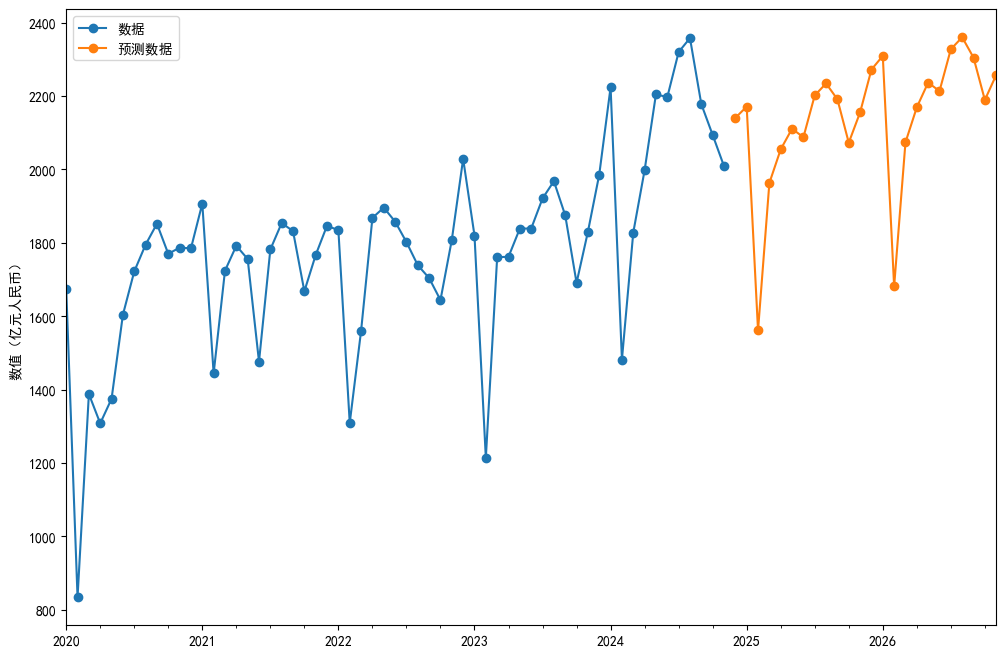

In [155]:
future_df[['数据', '预测数据']].plot(figsize=(12, 8), kind='line', marker='o') 
plt.ylabel('数值（亿元人民币）')
plt.show()

In [156]:
# 保存时间和预测数据列到Excel文件
future_df.to_excel('end_out.xlsx')